# Análise e Previsão de vendas para as lojas do Walmart 2013/1


## Organização
1. Entendimento do problema
2. Limpeza e extração de informações extras
3. Análise exploratória dos dados
4. Criação de moedelo preditivo
5. Validação do modelo criado
6. Apresentação dos resultados

# Entendimento do problema

O nosso objetivo aqui é basicamente analisar os dados, entender possíveis alterações no número de vendas dado a ocorrência de feriados, mensurar o desempenho dos setores e por fim fazer a previsão das vendas em um dado período futuro.

## Carga do dataset

In [1094]:
import pandas as pd
import numpy as np

import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from pandas import DataFrame
import numpy as np
from datetime import timedelta

import plotly.express as px
import plotly.graph_objects as go

In [1095]:
features = pd.read_csv('data/features.csv')
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [1096]:
stores = pd.read_csv('data/stores.csv')
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [1097]:
train = pd.read_csv('data/train.csv')
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [1098]:
test = pd.read_csv('data/test.csv')
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [1099]:
#Realizando soma para ver dados de lojas como um todo
train2 = train[['Date', 'Store', 'Weekly_Sales']].groupby(['Store', 'Date']).sum()
train2.reset_index(0, inplace=True)

In [1100]:
train2

,Store,Weekly_Sales
Date,,
2010-02-05,1,1643690.90
2010-02-12,1,1641957.44
2010-02-19,1,1611968.17
2010-02-26,1,1409727.59
2010-03-05,1,1554806.68
...,...,...
2012-09-28,45,713173.95
2012-10-05,45,733455.07
2012-10-12,45,734464.36


### Aqui temos 3 tabelas, sendo elas:
- Features: Dados resumidos das vendas de cada loja por semana
- Stores: Categoria (A, B e C) e tamanho das lojas
- Train: Dados de vendas de cada departamento e loja de acordo com a semana
- Test: Dados de cada departamento no período que queremos prever

In [1101]:
#Colocando infomações extras na nossa tabela de treino
df = train2.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
df.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,1643690.90,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,1641957.44,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,1611968.17,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,1409727.59,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,1554806.68,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [1102]:
df.rename(columns = {'IsHoliday':'Holiday_Flag'}, inplace = True)
df

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Holiday_Flag,Type,Size
0,1,2010-02-05,1643690.90,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,1641957.44,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,1611968.17,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,1409727.59,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,1554806.68,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,False,B,118221
6431,45,2012-10-05,733455.07,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,False,B,118221
6432,45,2012-10-12,734464.36,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,False,B,118221
6433,45,2012-10-19,718125.53,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,False,B,118221


### Checagem da qualidade dos dados entregues e adição de colunas

Faremos uma análise inicial do nosso dataset para descobrirmos possíveis problemas relativos à integridade dos nossos dados, como por exemplo, dados faltantes ou de tipagem errada. E caso possuam esses problemas, aplicaremos técnicas de Data Cleaning para a resolução desses problemas.
Além disso, iremos criar algumas colunas extras para que possamos extrair mais informações dos dados.

In [1103]:
df.head() # Ver amostra dos dados

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Holiday_Flag,Type,Size
0,1,2010-02-05,1643690.90,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,1641957.44,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,1611968.17,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,1409727.59,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,1554806.68,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [1104]:
df.shape #Checando quantidade de linhas e colunas do dataframe. 6435 linhas e 8 colunas

(6435, 15)

In [1105]:
df.info() # Ver quiais são os tipos das colunas, além de realizar a contagem de possíveis valores nulos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   MarkDown1     2280 non-null   float64
 6   MarkDown2     1637 non-null   float64
 7   MarkDown3     2046 non-null   float64
 8   MarkDown4     1965 non-null   float64
 9   MarkDown5     2295 non-null   float64
 10  CPI           6435 non-null   float64
 11  Unemployment  6435 non-null   float64
 12  Holiday_Flag  6435 non-null   bool   
 13  Type          6435 non-null   object 
 14  Size          6435 non-null   int64  
dtypes: bool(1), float64(10), int64(2), object(2)
memory usage: 760.4+ KB


### Criando colunas

Vamos criar uma nova coluna que indica exatamente em qual feriado estamos 

In [1106]:
christimas = {'2010-12-31': 'Natal',
            '2011-12-30': 'Natal',
            '2012-12-28': 'Natal',
            '2013-12-27': 'Natal'}

super_bowl = {'2010-02-12': 'Super Bowl',
            '2011-02-11': 'Super Bowl',
            '2012-02-10': 'Super Bowl',
            '2013-02-08': 'Super Bowl'}

labor_day = {'2010-09-10': 'Labor Day',
            '2011-09-09': 'Labor Day',
            '2012-09-07': 'Labor Day',
            '2013-09-06': 'Labor Day'}

thanksgiving = {'2010-11-26': 'Thanksgiving',
            '2011-11-25': 'Thanksgiving',
            '2012-11-23': 'Thanksgiving',
            '2013-11-29': 'Thanksgiving'}
map_dict = {}
map_dict.update(christimas)
map_dict.update(super_bowl)
map_dict.update(labor_day)
map_dict.update(thanksgiving)

df['Holiday'] = df['Date'].map(map_dict)
df['Holiday'] = df['Holiday'].fillna('Non-Holiday')


In [1107]:
df['Holiday'].value_counts()

Non-Holiday     5985
Super Bowl       135
Labor Day        135
Thanksgiving      90
Natal             90
Name: Holiday, dtype: int64

Note que a coluna referente a data está como object (tipo para armazenamento de texto), sendo que deveria ser do tipo datetime (para armazenar data). Podemos corrigir isso facilmente através do método pd.to_datetime()

In [1108]:
df.Date = pd.to_datetime(df['Date'], dayfirst=True)

In [1109]:
df.tail()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Holiday_Flag,Type,Size,Holiday
6430,45,2012-09-28,713173.95,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,False,B,118221,Non-Holiday
6431,45,2012-10-05,733455.07,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,False,B,118221,Non-Holiday
6432,45,2012-10-12,734464.36,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,False,B,118221,Non-Holiday
6433,45,2012-10-19,718125.53,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,False,B,118221,Non-Holiday
6434,45,2012-10-26,760281.43,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,False,B,118221,Non-Holiday


In [1110]:
# Criaremos colunas para a separação dos anos e meses e dias de início da semana, assim nos ajudando a entender melhor os nossos dados
# Extract the day, month, year from the Date column:
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.weekday
df['Month'] = df['Date'].dt.month
df['Year']  = df['Date'].dt.year
df.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Holiday_Flag,Type,Size,Holiday,Day,Month,Year
0,1,2010-02-05,1643690.90,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,Non-Holiday,4,2,2010
1,1,2010-02-12,1641957.44,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,Super Bowl,4,2,2010
2,1,2010-02-19,1611968.17,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,Non-Holiday,4,2,2010
3,1,2010-02-26,1409727.59,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,Non-Holiday,4,2,2010
4,1,2010-03-05,1554806.68,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,Non-Holiday,4,3,2010


In [1111]:
days = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5: 'Friday',6:'Saturday'}
df['Day'] = df['Day'].map(days)
months={
    1:'January',
    2:'February',
    3:'March',
    4:'April',
    5:'May',
    6:'June',
    7:'July',
    8:'August',
    9:'September',
    10:'October',
    11:'November',
    12:'December'}
df['Month_name'] = df['Month'].map(months)
df.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Holiday_Flag,Type,Size,Holiday,Day,Month,Year,Month_name
0,1,2010-02-05,1643690.90,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,Non-Holiday,Thursday,2,2010,February
1,1,2010-02-12,1641957.44,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,Super Bowl,Thursday,2,2010,February
2,1,2010-02-19,1611968.17,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,Non-Holiday,Thursday,2,2010,February
3,1,2010-02-26,1409727.59,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,Non-Holiday,Thursday,2,2010,February
4,1,2010-03-05,1554806.68,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,Non-Holiday,Thursday,3,2010,March


In [1112]:
#Removendo valores Nan de nossas colunas
features = features.fillna(0)

In [1113]:
#Preenchendo colubna de CPI (Não possui valores para o ano de 2013)
last_positive = features.CPI[features.CPI > 0].iloc[-1]
features.CPI = features.CPI.replace(0, last_positive)

In [1114]:
#Preenchendo colubna de CPI (Não possui valores para o ano de 2013)
last_positive = features.Unemployment[features.Unemployment > 0].iloc[-1]
features.Unemployment = features.Unemployment.replace(0, last_positive)

In [1115]:
features.CPI.value_counts()

193.589304    591
132.716097     33
139.122613     24
201.070571     12
224.802531     12
             ... 
215.932780      1
215.552886      1
215.172993      1
214.793099      1
219.197023      1
Name: CPI, Length: 2505, dtype: int64

# Análise Exploratória dos Dados

Aqui iremos analisar o dataset dado em busca de padrões e anomalias que possam nos ajudar a formular nossas hipóteses 

In [1116]:
#Sumário dos nossos números, assim conseguimos descobrir valores como médias, percentis e valores máximos e mínimos
df.describe()

,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Month,Year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,2280.000000,1637.000000,2046.000000,1965.000000,2295.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,60.663782,3.358607,6855.587430,3218.965504,1349.853021,3303.858142,4435.262240,171.578394,7.999151,130287.600000,6.447552,2010.965035
std,12.988182,5.643666e+05,18.444933,0.459020,8183.310015,9268.082387,9287.242800,6211.203947,5868.933325,39.356712,1.875885,63117.022465,3.238308,0.797019
min,1.000000,2.099862e+05,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000,1.000000,2010.000000
25%,12.000000,5.533501e+05,47.460000,2.933000,1679.190000,37.200000,4.700000,483.270000,1702.565000,131.735000,6.891000,70713.000000,4.000000,2010.000000
50%,23.000000,9.607460e+05,62.670000,3.445000,4972.590000,187.040000,22.700000,1419.420000,3186.520000,182.616521,7.874000,126512.000000,6.000000,2011.000000
75%,34.000000,1.420159e+06,74.940000,3.735000,8873.582500,1785.290000,99.987500,3496.080000,5422.080000,212.743293,8.622000,202307.000000,9.000000,2012.000000
max,45.000000,3.818686e+06,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,12.000000,2012.000000


### Algumas asserções que podemos fazer com essas informações


#### Vendas Semanais
Esse é o número no qual nossa análise estará focada, pois essa é a nossa variável dependente, da qual todas as outras poderão influenciar.
- Podemos ver que o valor máximo vendido em uma semana foi pouco abaixo de 4 milhões;
- A média do valor vendido se situa em 1 milhão por mês.

#### Temperatura
- A temperadura média é de 60Fº, cerca de 15 graus Celsius, chegando à mínima de -2F (-16ºC) e à máxima de 100Fº (40º Celsius);
- Olhando em termos de percentis, notamos que 75% das amostras não passam de 74Fº (23ºC). O que nos permite inferir que o clima na maior parte do tempo é de frio.

#### Preço do combustível, CPI e Desemperego
Essas são variáveis que potencialmente podem atrapalhar as vendas semanais. E essas são as razões.
Quanto maior o preço do combustível, podemos ter um acrésimo nos preços devido a questões de logística, além de um decrésimo no interesse das pessoas em dirigir até o Walmart devido ao aumento no preço da gasolina. 

O CPI (Consumer Price Index) é o equivalente ao nosso IPC, que mede a inflação dos produtos vendidos. Então é lógico inferir que quanto maior a inflação, maior os preços, o que poderá influenciar de dois modos o nosso indicador de vendas semanais:
 - Com preços mais altos, o volume de vendas irá diminuir, já que alguns produtos menos essenciais não serão mais comprados por algumas pessoas.
 - Com preços mais altos, o valor das vendas poderá aumentar, já que produtos essenciais irão custar mais.

## Comparando feriados com não-feriados

Como primeira análise podemos ver quantos registros de feriados e não-feriados temos

In [1117]:
# Importando Plotly, que nos ajudará a fazer alguns gráficos para visualizarmos melhor os dados 


In [1118]:
#Fazendo algumas operações que ajudam na estética do nosso gráfico
contagem = df.Holiday_Flag
contagem = contagem.apply(lambda x: 'Feriado' if x else 'Semana Normal')
contagem = contagem.value_counts()
contagem

Semana Normal    5985
Feriado           450
Name: Holiday_Flag, dtype: int64

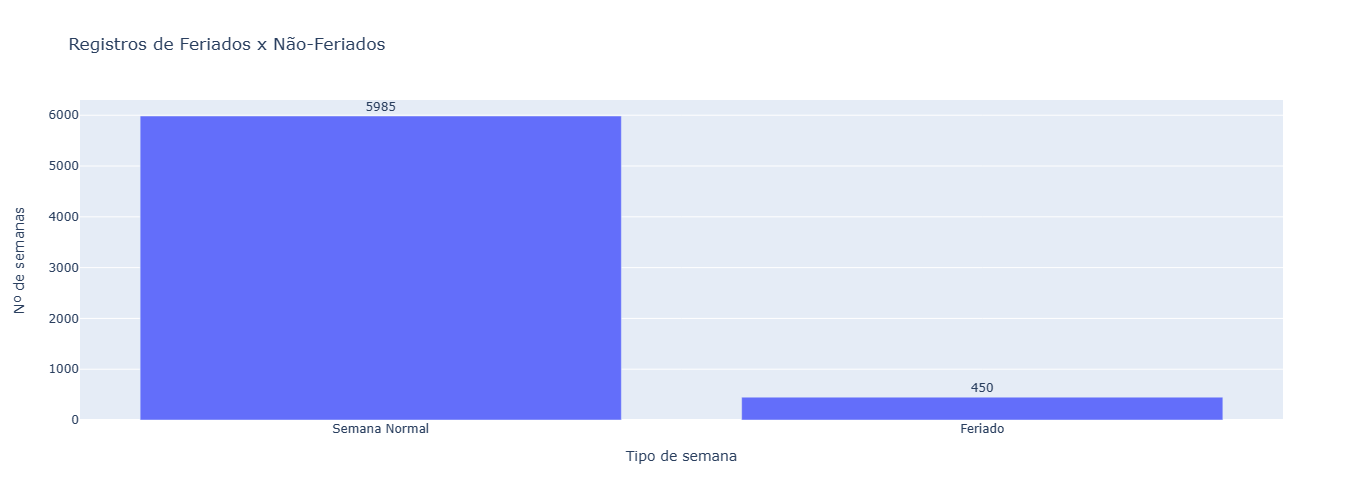

In [1119]:
fig = px.bar(contagem,
       title='Registros de Feriados x Não-Feriados',
       labels={'index': 'Tipo de semana', 'value':'Nº de semanas'},
       text_auto=True,
       width=700, height=500)

fig.update_traces(showlegend=False,
                  textposition="outside")
fig.show()

Ao olhar nossos números notamos que de um total de 6435 registros, das quais 93% são de semanas onde não ocorrem feriados contra 7% onde eles efetivamente ocorrem

### Vamos comparar as vendas ao longo dos anos

In [1120]:
vendas_por_ano = df[['Weekly_Sales', 'Year']].groupby(['Year']).sum()


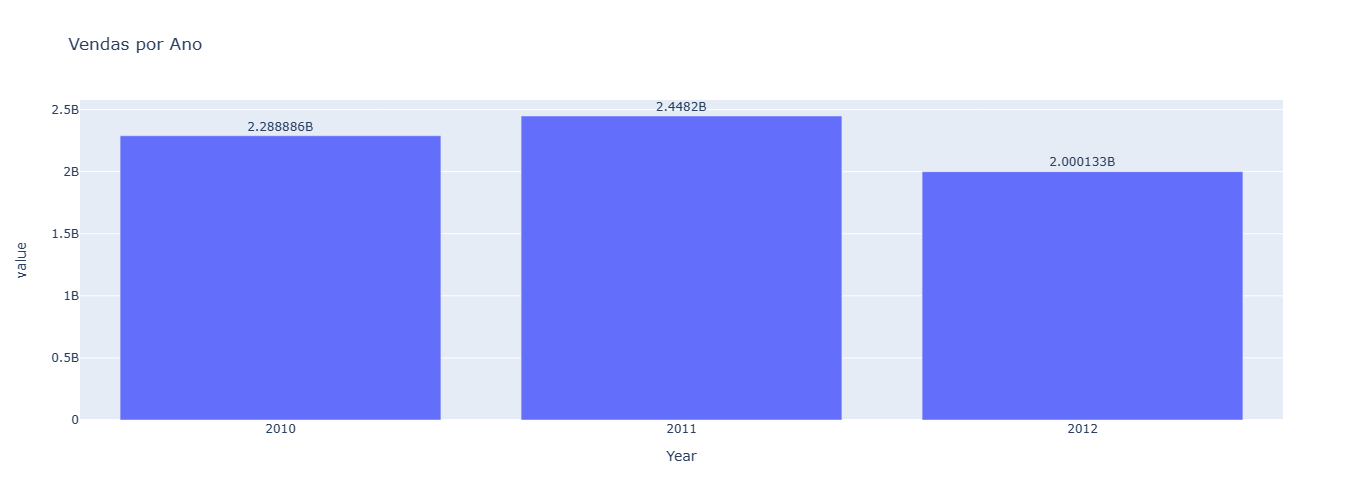

In [1121]:
fig = px.bar(vendas_por_ano,    
       title='Vendas por Ano',
       text_auto=True,
       width=700, height=500)

fig.update_traces(showlegend=False,
                  textposition="outside")
fig.update_xaxes(type='category')
fig.show()

In [1122]:
vendas_por_ano_em_feriados = df[['Holiday_Flag', 'Weekly_Sales', 'Year']].groupby(['Holiday_Flag', 'Year'], as_index=False).mean()

In [1123]:
# vendas_por_ano_em_feriados = vendas_por_ano_em_feriados.reset_index(0)
# vendas_por_ano_em_feriados = vendas_por_ano_em_feriados.reset_index(0)

In [1124]:
vendas_por_ano_em_feriados

,Holiday_Flag,Year,Weekly_Sales
0,False,2010,1.054880e+06
1,False,2011,1.037715e+06
2,False,2012,1.030782e+06
3,True,2010,1.112359e+06
4,True,2011,1.148530e+06
5,True,2012,1.092661e+06


In [1125]:
vendas_por_ano_em_feriados.Holiday_Flag = vendas_por_ano_em_feriados.Holiday_Flag.map({False: 'Semana Normal', True:'Semana de Feriado'})

In [1126]:
vendas_por_ano_em_feriados

,Holiday_Flag,Year,Weekly_Sales
0,Semana Normal,2010,1.054880e+06
1,Semana Normal,2011,1.037715e+06
2,Semana Normal,2012,1.030782e+06
3,Semana de Feriado,2010,1.112359e+06
4,Semana de Feriado,2011,1.148530e+06
5,Semana de Feriado,2012,1.092661e+06


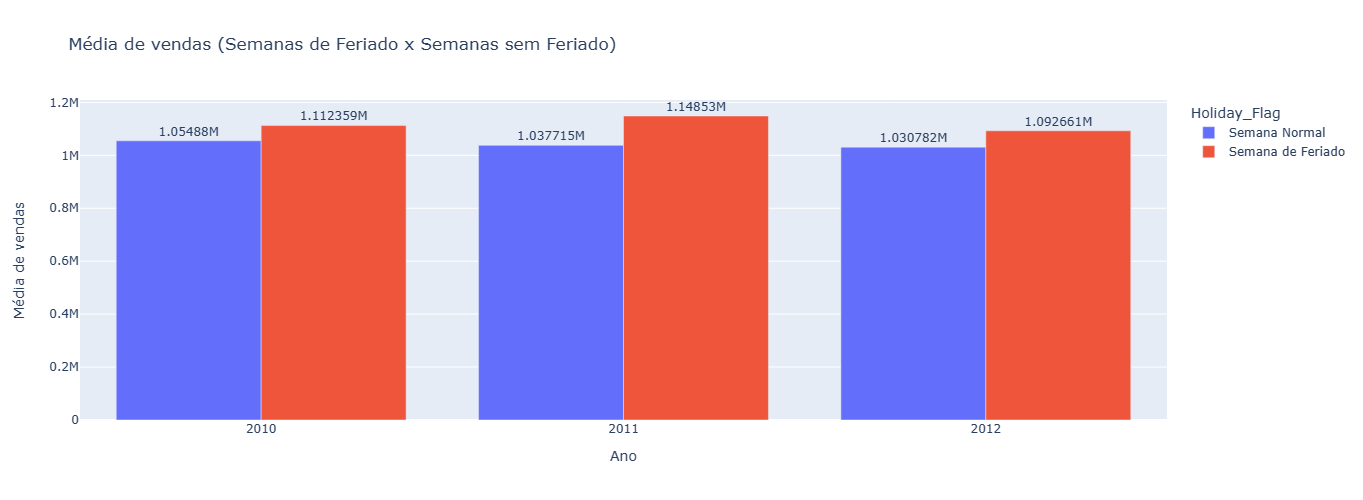

In [1127]:

fig = px.bar(vendas_por_ano_em_feriados,
       x='Year',
       y='Weekly_Sales',
       color='Holiday_Flag',
       title='Média de vendas (Semanas de Feriado x Semanas sem Feriado)',
       labels={'Year': 'Ano', 'Weekly_Sales':'Média de vendas'},
       barmode='group',
       text_auto=True,
       width=700, height=500)

fig.update_traces(showlegend=True,
                  textposition="outside"
                 )
fig.show()

#### À primeira vista, podemos notar um acréscimo nas vendas quando estamos tratando de semanas em que ocorrem feriados.
Mas e se nós quisermos ir além e saber exatamente como cada feriado especificamente impacta nas vendas?

In [1128]:
vendas_por_ano_de_acordo_com_o_feriado = df[['Holiday', 'Weekly_Sales', 'Year']].groupby(['Holiday', 'Year'], as_index=False).mean()
# vendas_por_ano_de_acordo_com_o_feriado = vendas_por_ano_de_acordo_com_o_feriado.reset_index(0)
# vendas_por_ano_de_acordo_com_o_feriado = vendas_por_ano_de_acordo_com_o_feriado.reset_index(0)

In [1129]:
vendas_por_ano_de_acordo_com_o_feriado

,Holiday,Year,Weekly_Sales
0,Labor Day,2010,1.014098e+06
1,Labor Day,2011,1.039183e+06
2,Labor Day,2012,1.074001e+06
3,Natal,2010,8.985004e+05
4,Natal,2011,1.023166e+06
5,Non-Holiday,2010,1.054880e+06
6,Non-Holiday,2011,1.037715e+06
7,Non-Holiday,2012,1.030782e+06
8,Super Bowl,2010,1.074148e+06
9,Super Bowl,2011,1.051915e+06


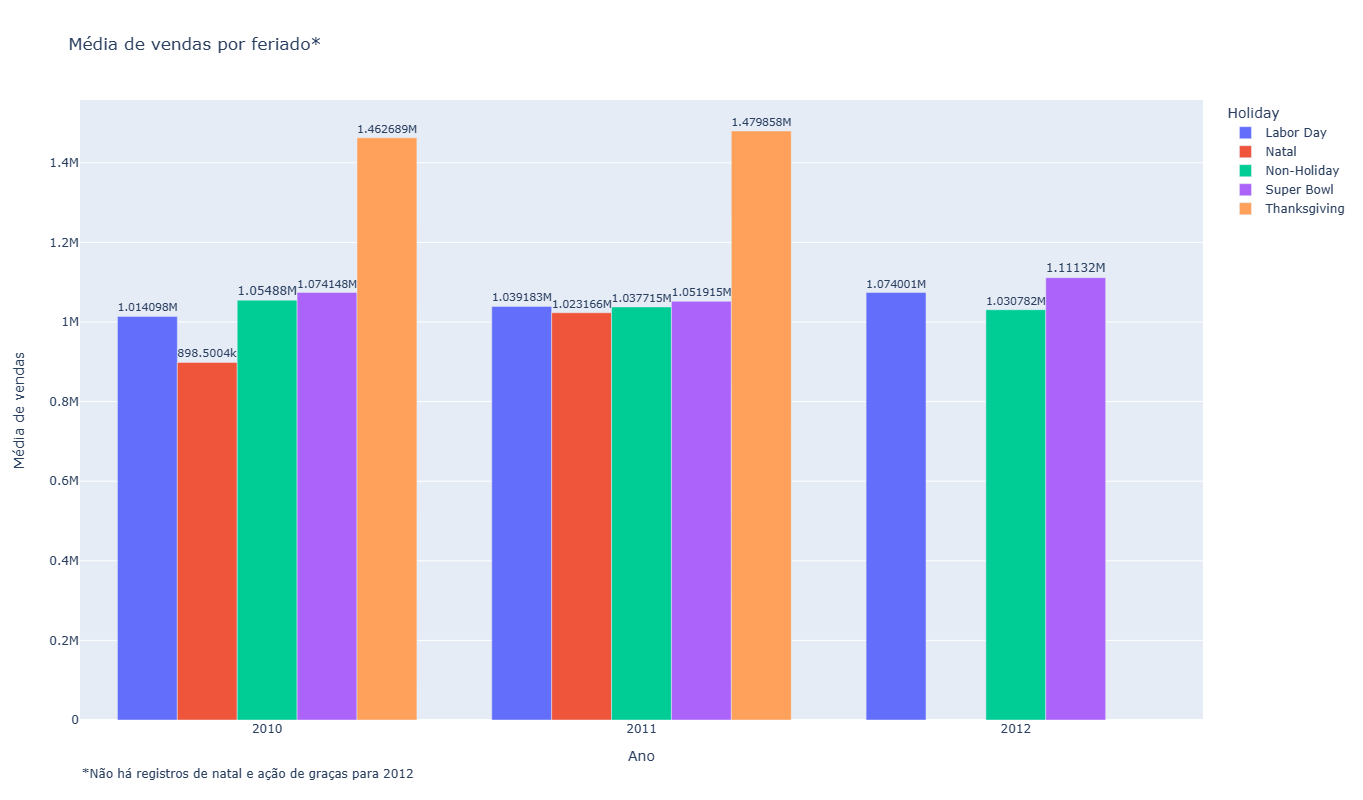

In [1130]:

fig = px.bar(vendas_por_ano_de_acordo_com_o_feriado,
       x='Year',
       y='Weekly_Sales',
       color='Holiday',
       title='Média de vendas por feriado*',
       labels={'Year': 'Ano', 'Weekly_Sales':'Média de vendas'},
       barmode='group',
       text_auto=True,
       width=1200, height=800)

fig.update_traces(showlegend=True,
                  textposition="outside"
                 )
fig.add_annotation(
    text="*Não há registros de natal e ação de graças para 2012",
    xref="paper", yref="paper",
    x=0, y=-0.1,
    showarrow=False
)


fig.show()

### Pontos a se notar

Um ponto interessante de se notar é o de que o feriado que mais produz lucratividade na semana em que ocorre é o de ação de graças, isso se deve, provavelmente pela ocorrência da black friday.

Outro ponto é que vemos que feriados como o Super Bowl e o Dia do Trabalho não mostram um aumento sólido nas vendas gerais, oscilando muito pouco em torno da média de vendas das semanas sem feriados.

O natal aparentemente mostra um decréscimo nas vendas, podemos formular uma hipótese de que isso pode ser devido ao fato de que as compras para o natal geralmente ocorrem semanas antes do feriado em si.

### Para provar a nossa hipótese anterior, vamos ver a média de vendas no mês do natal e comparar elas com os meses anteriores

In [1131]:
vendas_por_semana = df[['Date', 'Weekly_Sales', 'Year', 'Month']].groupby(['Year', 'Month'], as_index=False).mean()

C:\Users\vinic\AppData\Local\Temp\ipykernel_8348\3859328463.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [1132]:
vendas_por_semana
vendas_por_semana['Date'] = pd.Series([f'{month}-{year}' for month, year in zip(list(vendas_por_semana.Month), list(vendas_por_semana.Year)) ])
vendas_por_semana

,Year,Month,Weekly_Sales,Date
0,2010,2,1.057405e+06,2-2010
1,2010,3,1.010666e+06,3-2010
2,2010,4,1.028499e+06,4-2010
3,2010,5,1.037283e+06,5-2010
4,2010,6,1.068034e+06,6-2010
5,2010,7,1.033689e+06,7-2010
6,2010,8,1.042445e+06,8-2010
7,2010,9,9.848216e+05,9-2010
8,2010,10,9.651637e+05,10-2010
9,2010,11,1.126963e+06,11-2010


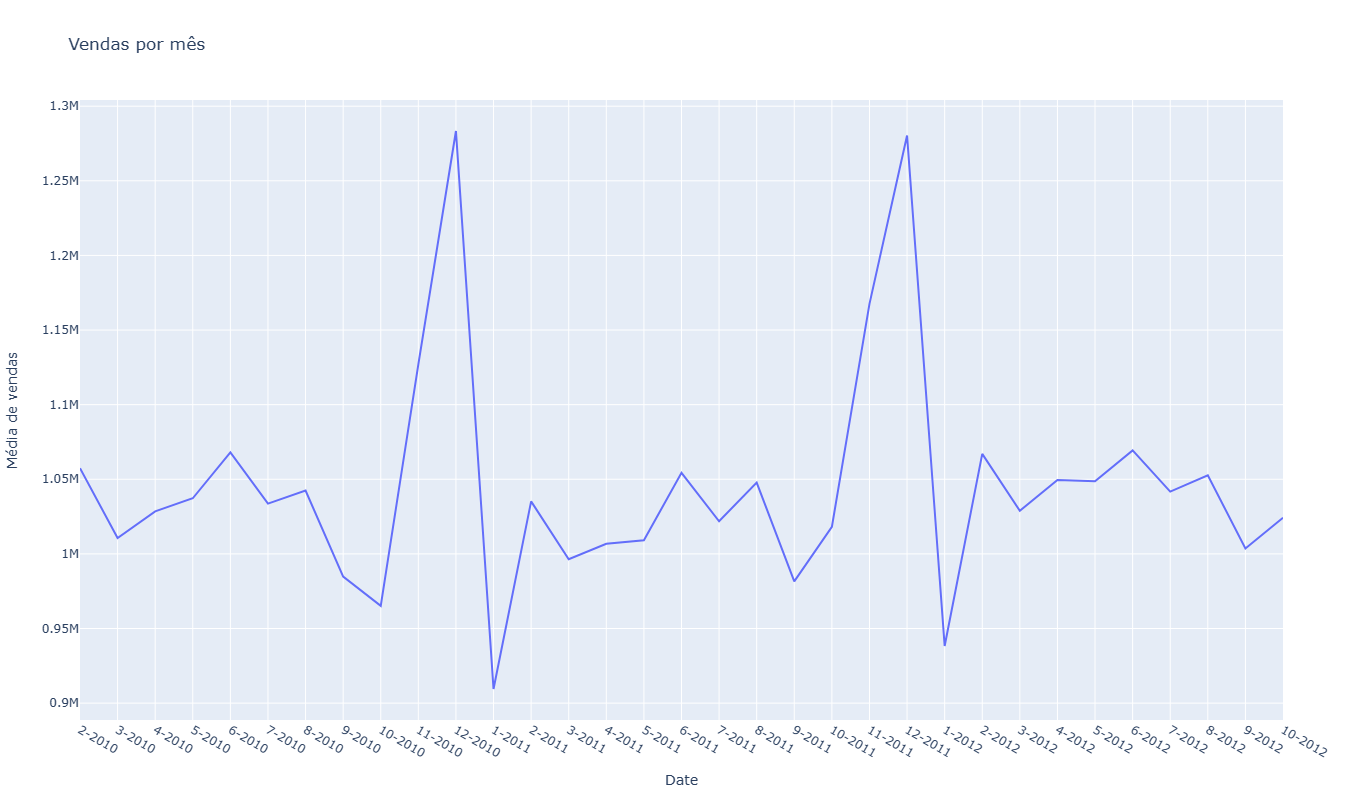

In [1133]:

fig = px.line(vendas_por_semana,
       x='Date',
       y='Weekly_Sales',
       title='Vendas por mês',
       labels={'Year': 'Ano', 'Weekly_Sales':'Média de vendas'},

       width=1200, height=800)




fig.show()

### Notem os picos que ocorrem nos meses 11 e 12, enquanto os picos do mês 11 são causados pela Black Friday, os picos de dezembro podem ser explicados pelas compras que antecedem o natal

In [1134]:
## Vamos análisar os dados por departamento

In [1135]:
vendas_por_departamento = train.groupby(['Dept', 'IsHoliday'], as_index=False).mean()
vendas_por_departamento

C:\Users\vinic\AppData\Local\Temp\ipykernel_8348\388856872.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Dept,IsHoliday,Store,Weekly_Sales
0,1,False,23.000000,19176.542652
1,1,True,23.000000,19704.819489
2,2,False,23.000000,43712.565666
3,2,True,23.000000,42203.264267
4,3,False,23.000000,11764.630795
...,...,...,...,...
157,97,True,23.385845,14004.165525
158,98,False,24.184269,6764.637219
159,98,True,24.040476,7599.152833
160,99,False,21.490222,311.443638


In [1136]:
vendas_por_departamento

,Dept,IsHoliday,Store,Weekly_Sales
0,1,False,23.000000,19176.542652
1,1,True,23.000000,19704.819489
2,2,False,23.000000,43712.565666
3,2,True,23.000000,42203.264267
4,3,False,23.000000,11764.630795
...,...,...,...,...
157,97,True,23.385845,14004.165525
158,98,False,24.184269,6764.637219
159,98,True,24.040476,7599.152833
160,99,False,21.490222,311.443638


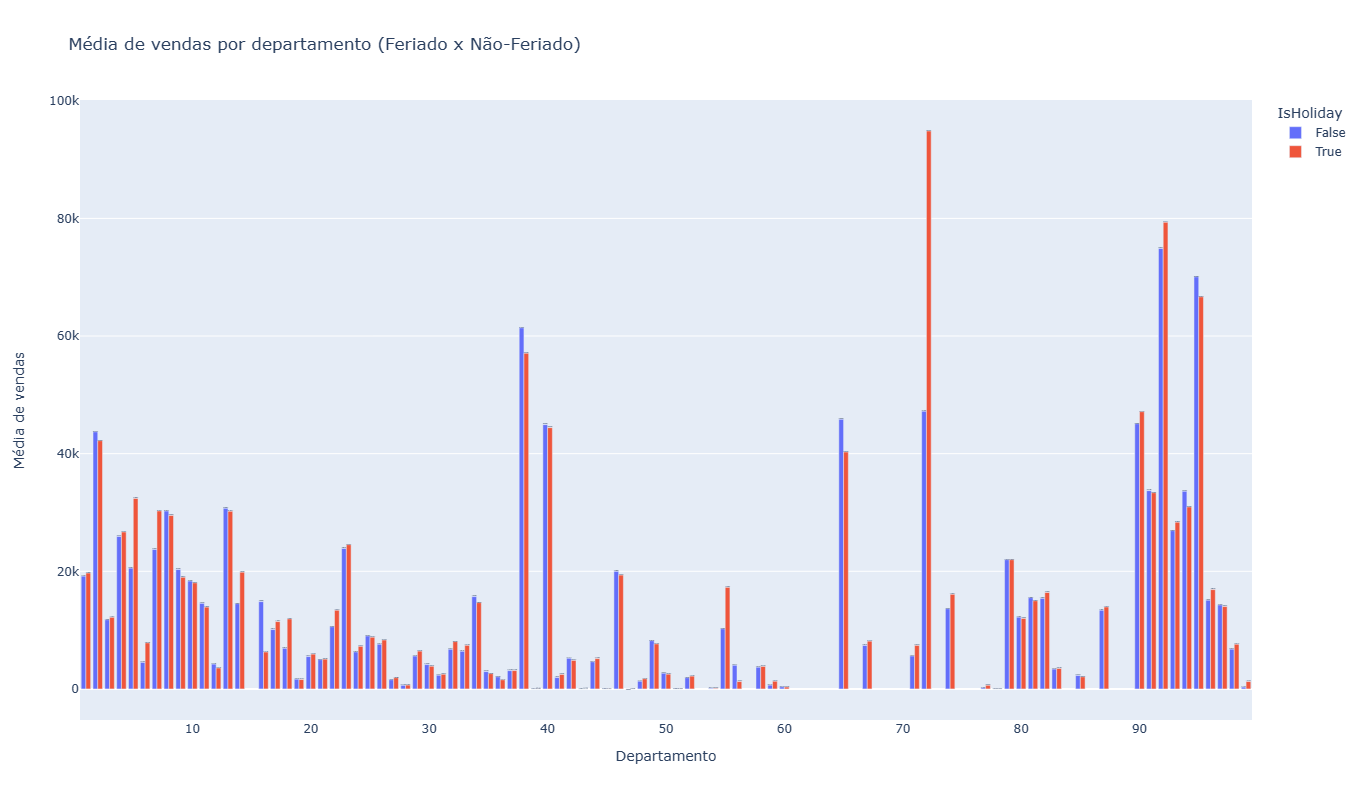

In [1137]:

fig = px.bar(vendas_por_departamento,
       x='Dept',
       y='Weekly_Sales',
       color='IsHoliday',
       title='Média de vendas por departamento (Feriado x Não-Feriado)',
       labels={'Year': 'Ano', 'Weekly_Sales':'Média de vendas', 'Dept': 'Departamento'},
       barmode='group',
       text_auto=True,
       width=1200, height=800)

fig.update_traces(showlegend=True,
                  textposition="outside")



fig.show()

### Podemos ver que na maioria dos departamentos, a média de vendas continua a mesma coisa quando há e quando não há feriado. Vamos focar a nossa análise nos poucos departamentos que mostram uma melhora significativa (mais de 10%) quando há feriado

In [1138]:
departamentos_com_aumento_de_vendas = []
for i in vendas_por_departamento.Dept.unique():
    holiday_sales = vendas_por_departamento[(vendas_por_departamento['Dept'] == i) & (vendas_por_departamento['IsHoliday'] == True)].Weekly_Sales.iloc[0]
    non_holiday_sales = vendas_por_departamento[(vendas_por_departamento['Dept'] == i) & (vendas_por_departamento['IsHoliday'] == False)].Weekly_Sales.iloc[0]
    if holiday_sales >= 1.1 * non_holiday_sales:
        departamentos_com_aumento_de_vendas.append(i)

In [1139]:
departamentos_com_aumento_de_vendas

[5,
 6,
 7,
 14,
 17,
 18,
 22,
 24,
 27,
 29,
 32,
 33,
 39,
 41,
 44,
 47,
 48,
 52,
 55,
 59,
 71,
 72,
 74,
 77,
 96,
 98,
 99]

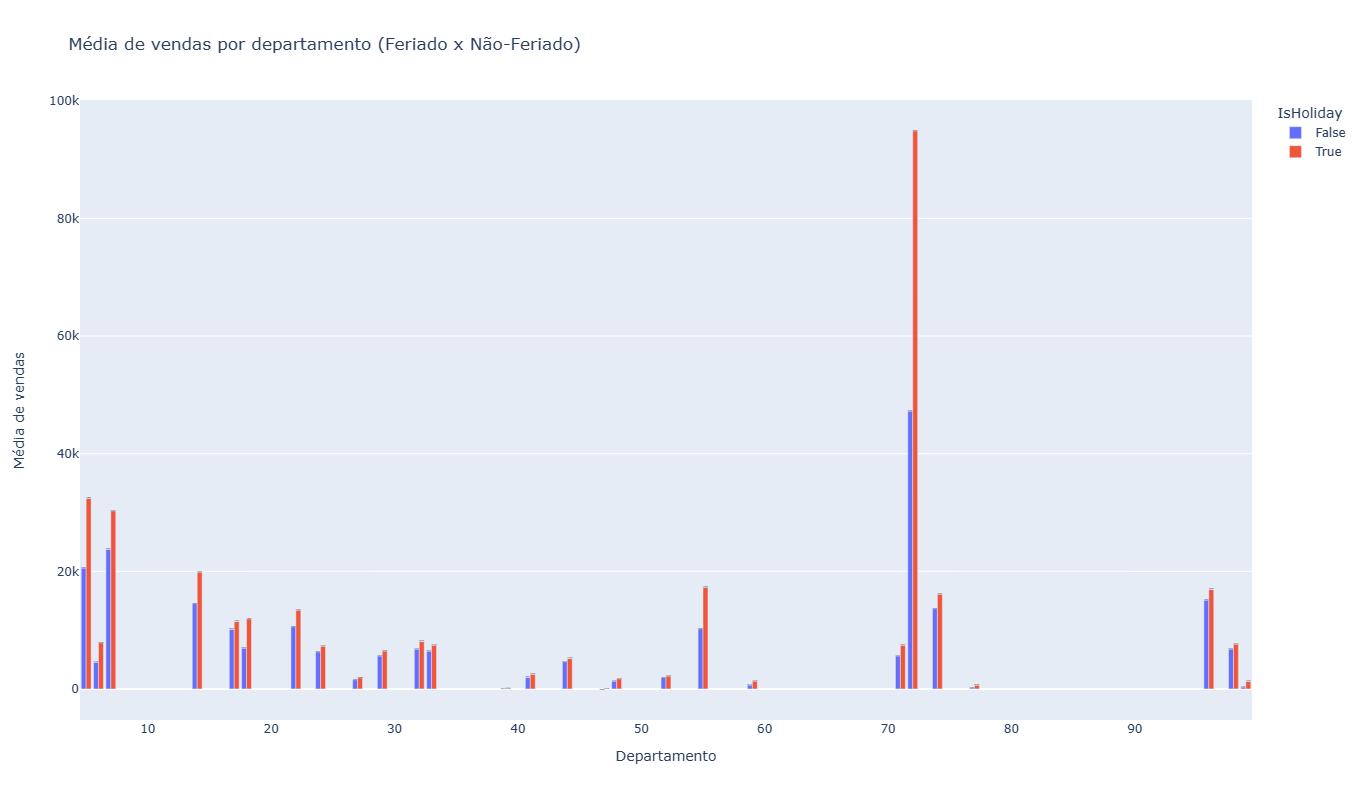

In [1140]:

fig = px.bar(vendas_por_departamento[vendas_por_departamento['Dept'].isin(departamentos_com_aumento_de_vendas)],
       x='Dept',
       y='Weekly_Sales',
       color='IsHoliday',
       title='Média de vendas por departamento (Feriado x Não-Feriado)',
       labels={'Year': 'Ano', 'Weekly_Sales':'Média de vendas', 'Dept': 'Departamento'},
       barmode='group',
       text_auto=True,
       width=1200, height=800)

fig.update_traces(showlegend=True,
                  textposition="outside")



fig.show()

Esses são os departamentos que claramente se saem melhor quando há presença de feriados

# Criação de moedelo preditivo

### primeiramente, irei adicionar as features para cada linha, assim teremos mais informação para alimentar nosso modelo

In [1141]:
# Adicionar mais features através de merge
train_1 = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')

# Renomear e excluir coluna repetida criada no merge
train_1.rename({'IsHoliday_x': 'Holiday_Flag'}, axis=1, inplace=True)
train_1.drop('IsHoliday_y', axis=1, inplace=True)

# Aplicar one_hot_encoding nos nossos dados de loja (nos ajuda com modelos que trabalham com dados não-categoricos)
one_hot = pd.get_dummies(train_1['Type'], prefix='store_type_')
train_1.drop('Type', axis=1, inplace=True)
train_1 = train_1.join(one_hot)

# Preencher valores NaN com 0
train_1 = train_1.fillna(0)

#Criando novas coluna para data
train_1['Date'] = pd.to_datetime(train_1['Date']) 
train_1['Week'] = train_1['Date'].dt.isocalendar().week
train_1['Month'] = train_1['Date'].dt.month
# Como vamos fazer a previsão de vendas de cada loja, vamos juntar as vendas semainais de cada departamento 
train_2 = train_1.groupby(['Store', 'Date', 'Month', 'Week', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'MarkDown1' , 'MarkDown2', 'MarkDown3' , 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'store_type__A', 'store_type__B', 'store_type__C'
], as_index=False)[['Weekly_Sales']].apply(lambda x: x.sum())

#Salvando a coluna de data para uso posterior
train_2_date = train_2.Date

train_2 = train_2.drop(['Date'], axis=1)
train_2

,Store,Month,Week,Holiday_Flag,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,store_type__A,store_type__B,store_type__C,Weekly_Sales
0,1,2,5,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,151315,1,0,0,1643690.90
1,1,2,6,True,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,151315,1,0,0,1641957.44
2,1,2,7,False,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,151315,1,0,0,1611968.17
3,1,2,8,False,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,151315,1,0,0,1409727.59
4,1,3,9,False,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,151315,1,0,0,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,9,39,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,118221,0,1,0,713173.95
6431,45,10,40,False,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,118221,0,1,0,733455.07
6432,45,10,41,False,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,118221,0,1,0,734464.36
6433,45,10,42,False,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,118221,0,1,0,718125.53


In [1142]:
test_1 = test.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')

test_1.rename({'IsHoliday_x': 'Holiday_Flag'}, axis=1, inplace=True)
test_1.drop('IsHoliday_y', axis=1, inplace=True)

# Aplicar one_hot_encoding nos nossos dados de loja (nos ajuda com modelos que trabalham com dados não-categoricos)
one_hot = pd.get_dummies(test_1['Type'], prefix='store_type_')
test_1.drop('Type', axis=1, inplace=True)
test_1 = test_1.join(one_hot)

# Preencher valores NaN com 0
test_1 = test_1.fillna(0)

#Criando novas coluna para data
test_1['Date'] = pd.to_datetime(test_1['Date']) 
test_1['Week'] = test_1['Date'].dt.isocalendar().week
test_1['Month'] = test_1['Date'].dt.month

# Como vamos fazer a previsão de vendas de cada loja, vamos juntar as vendas semainais de cada departamento 
test_1 = test_1.fillna(0)
test_2 = test_1.groupby(['Store', 'Date', 'Month', 'Week', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'MarkDown1' , 'MarkDown2', 'MarkDown3' , 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'store_type__A', 'store_type__B', 'store_type__C' ], as_index=False).sum()
test_2 = test_2.drop(['Dept'], axis=1)


#Salvando a coluna de data para uso posterior
test_2_date = test_2.Date


test_2 = test_2.drop(['Date'], axis=1)

test_2.head(5)

,Store,Month,Week,Holiday_Flag,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,store_type__A,store_type__B,store_type__C
0,1,11,44,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,151315,1,0,0
1,1,11,45,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,151315,1,0,0
2,1,11,46,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,151315,1,0,0
3,1,11,47,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,151315,1,0,0
4,1,11,48,False,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,151315,1,0,0


Vamos olhar a correlação entre as colunas, isso nos ajuda a apagar variáveis dependentes das outras, além de variáveis que não influenciam na nossa variável alvo

C:\Users\vinic\AppData\Local\Temp\ipykernel_8348\1245470941.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



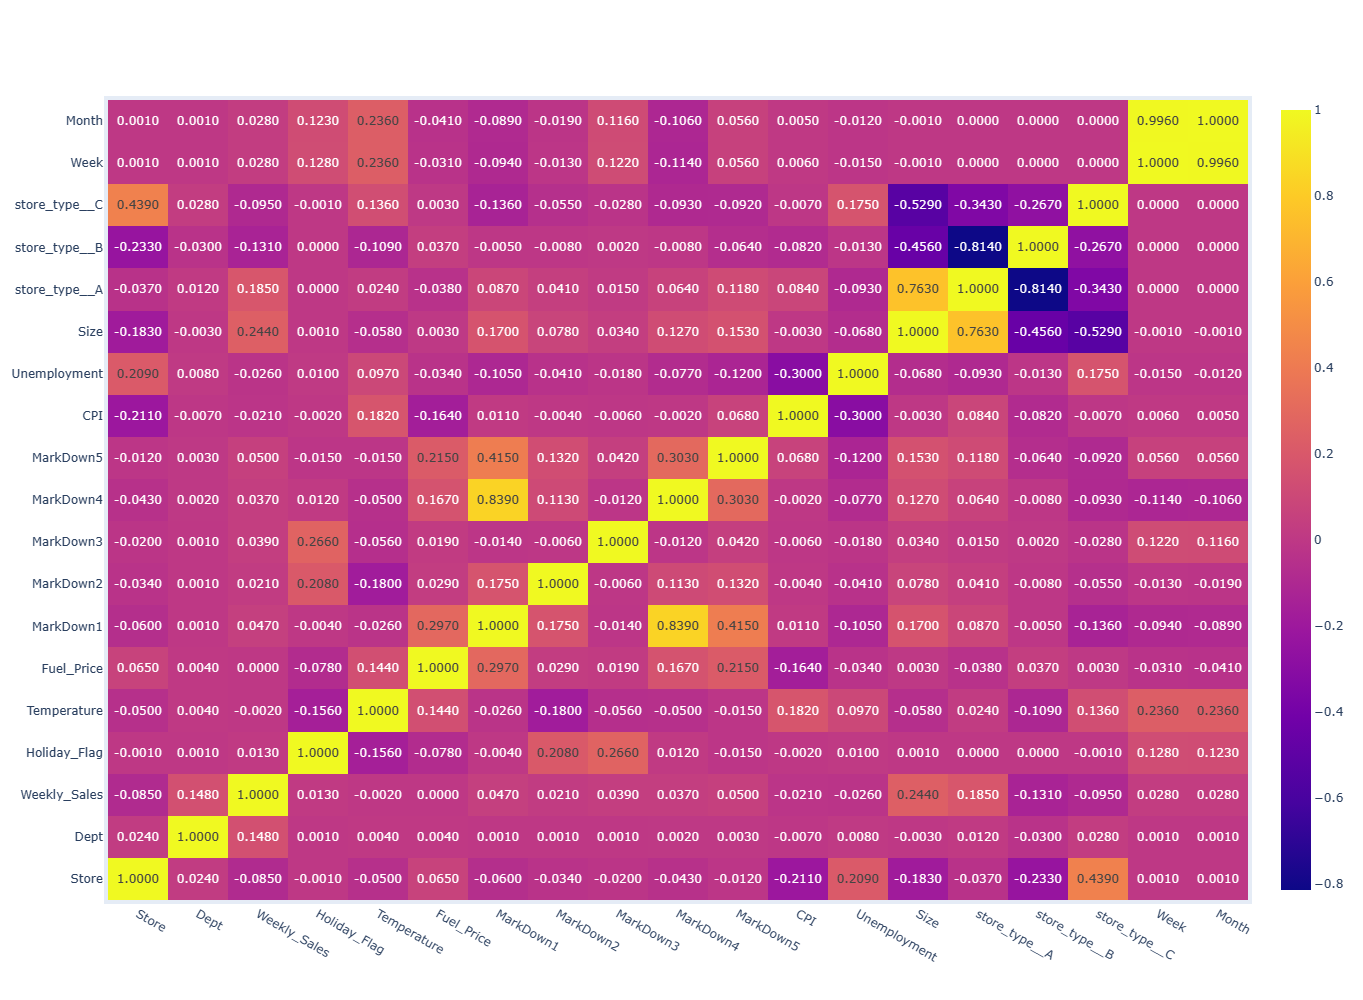

In [1143]:
import plotly.graph_objects as go

# Correlation
df_corr = train_1.corr().round(3)  
fig = go.Figure()

fig.add_trace(
    go.Heatmap(
        x = df_corr.columns,
        y = df_corr.index,
        z = np.array(df_corr),
        text=df_corr.values,
        texttemplate='%{text:.4f}',
        
    ),
)

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

fig.show()

In [1144]:
test_2.shape

(1755, 17)

In [1145]:
train_2.shape
test_2

,Store,Month,Week,Holiday_Flag,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,store_type__A,store_type__B,store_type__C
0,1,11,44,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,151315,1,0,0
1,1,11,45,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,151315,1,0,0
2,1,11,46,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,151315,1,0,0
3,1,11,47,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,151315,1,0,0
4,1,11,48,False,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,151315,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750,45,6,26,False,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,193.589304,8.335,118221,0,1,0
1751,45,7,27,False,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,193.589304,8.335,118221,0,1,0
1752,45,7,28,False,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,193.589304,8.335,118221,0,1,0
1753,45,7,29,False,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,193.589304,8.335,118221,0,1,0


In [1146]:
test_2 = test_2.drop(['CPI', 'Unemployment', 'MarkDown5', 'MarkDown4', 'Size'], axis=1)
train_2 =train_2.drop(['CPI', 'Unemployment', 'MarkDown5', 'MarkDown4', 'Size'], axis=1)

In [1147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_2.drop('Weekly_Sales', axis=1), train_2['Weekly_Sales'], test_size=0.1, random_state=42)

In [1148]:
X_train

,Store,Month,Week,Holiday_Flag,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,store_type__A,store_type__B,store_type__C
2577,19,2,8,False,30.33,2.910,0.00,0.00,0.0,1,0,0
3433,25,2,6,True,19.64,2.773,0.00,0.00,0.0,0,1,0
3011,22,4,13,False,44.96,2.826,0.00,0.00,0.0,0,1,0
6053,43,12,52,True,48.61,2.943,0.00,0.00,0.0,0,0,1
19,1,6,24,False,84.11,2.637,0.00,0.00,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3772,27,2,7,False,39.32,3.420,0.00,0.00,0.0,1,0,0
5191,37,12,48,False,54.44,2.708,0.00,0.00,0.0,0,0,1
5226,37,8,31,False,86.71,3.684,0.00,0.00,0.0,0,0,1
5390,38,12,52,True,44.64,3.428,353.07,1926.94,0.0,0,0,1


In [1149]:
print("Starting model train..")
rfe = RFE(RandomForestRegressor(n_estimators=1000, random_state=1), n_features_to_select=10)
fit = rfe.fit(X_train, y_train)
y_pred = fit.predict(X_test)

Starting model train..


### Vendo algumas métricas

In [1151]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

print(f'MAE: {median_absolute_error(y_true, y_pred)}')
print(f'ME: {max_error(y_true, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')
print(f'MAE: {mean_absolute_error(y_true, y_pred)}')

MAE: 32134.39585501392
ME: 1192085.8820899744
MAPE: 0.05621056052386809
MAE: 61002.597702360625


In [1153]:
pred = fit.predict(test_2)

In [1154]:
train_2 = train_2.join(train_2_date)

In [1155]:
test_2 = test_2.join(test_2_date)

In [1156]:
predicted_df = pd.concat([test_2, pd.Series(pred)], axis=1)

In [1157]:
predicted_df = predicted_df.rename({0: 'Weekly_Sales'}, axis=1)

### Aplicação do modelo

In [1185]:
# Vamos ver como ele iria preveras vendas de uma detrminada loja
loja_alvo = 10

train_mask = train_2.Store == loja_alvo
test_mask = test_2.Store == loja_alvo

train_2[mask]

,Store,Month,Week,Holiday_Flag,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,store_type__A,store_type__B,store_type__C,Weekly_Sales,Date
0,1,2,5,False,42.31,2.572,0.00,0.00,0.00,1,0,0,1643690.90,2010-02-05
1,1,2,6,True,38.51,2.548,0.00,0.00,0.00,1,0,0,1641957.44,2010-02-12
2,1,2,7,False,39.93,2.514,0.00,0.00,0.00,1,0,0,1611968.17,2010-02-19
3,1,2,8,False,46.63,2.561,0.00,0.00,0.00,1,0,0,1409727.59,2010-02-26
4,1,3,9,False,46.50,2.625,0.00,0.00,0.00,1,0,0,1554806.68,2010-03-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,1,9,39,False,76.08,3.666,3666.27,7.64,1.65,1,0,0,1437059.26,2012-09-28
139,1,10,40,False,68.55,3.617,8077.89,0.00,18.22,1,0,0,1670785.97,2012-10-05
140,1,10,41,False,62.99,3.601,2086.18,0.00,8.11,1,0,0,1573072.81,2012-10-12
141,1,10,42,False,67.97,3.594,950.33,0.00,4.93,1,0,0,1508068.77,2012-10-19


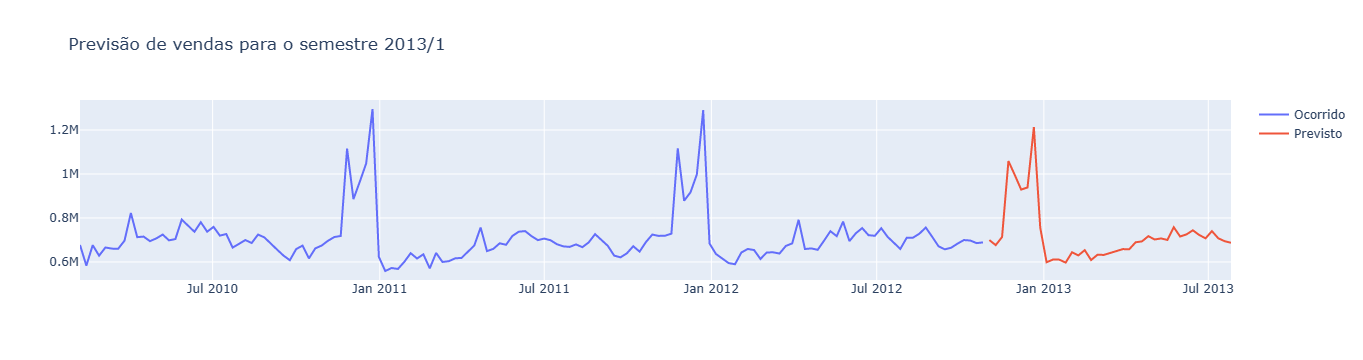

In [1186]:
# Create traces
fig = go.Figure(layout={'title':'Previsão de vendas para o semestre 2013/1'})
fig.add_trace(go.Scatter(x=train_2[train_mask].Date,y=train_2[train_mask].Weekly_Sales,
                    mode='lines',
                    name='Ocorrido'))

fig.add_trace(go.Scatter(x=predicted_df[test_mask].Date, y=predicted_df[test_mask].Weekly_Sales,
                    mode='lines',
                    name='Previsto'))

fig.show()

### Vamos ver as previsões para a venda de todas as lojas somadas

In [1191]:
all_df = pd.concat([train_2, predicted_df], axis=0)


In [1192]:
vendas_gerais = all_df[['Date', 'Weekly_Sales']].groupby(['Date'], as_index=False).sum()

In [1193]:
vendas_gerais

,Date,Weekly_Sales
0,2010-02-05,4.975074e+07
1,2010-02-12,4.833668e+07
2,2010-02-19,4.827699e+07
3,2010-02-26,4.396857e+07
4,2010-03-05,4.687147e+07
...,...,...
177,2013-06-28,4.769643e+07
178,2013-07-05,4.923977e+07
179,2013-07-12,4.741206e+07
180,2013-07-19,4.671313e+07


In [1194]:
date_mask = vendas_gerais.Date <= '2012-11-1'

In [1195]:
~date_mask

0      False
1      False
2      False
3      False
4      False
       ...  
177     True
178     True
179     True
180     True
181     True
Name: Date, Length: 182, dtype: bool

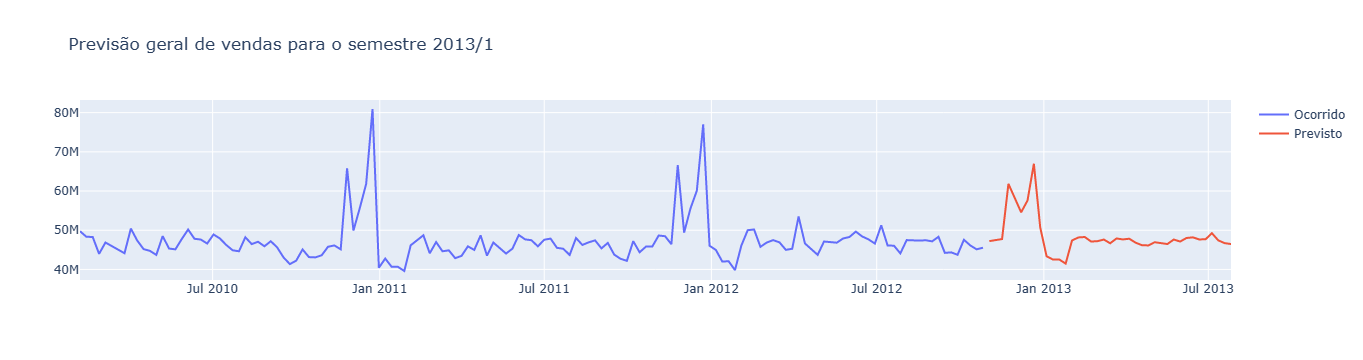

In [1196]:
fig = go.Figure(layout={'title':'Previsão geral de vendas para o semestre 2013/1 '})
fig.add_trace(go.Scatter(x=vendas_gerais[date_mask].Date, y=vendas_gerais[date_mask].Weekly_Sales,
                    mode='lines',
                    name='Ocorrido'))

fig.add_trace(go.Scatter(x=vendas_gerais[~date_mask].Date, y=vendas_gerais[~date_mask].Weekly_Sales,
                    mode='lines',
                    name='Previsto'))
fig.show()

## Conclusão

O modelo criado mostrou funcionar bem. Conseguindo prever com certa acurácia as tendências de venda, enquanto mostra uma certa dificuldade em prever picos e vales. No entanto, para um uso geral, temos um bom modelo.

Além disso, criei um slide para simular como eu faria uma apresentação dos resultados obtidos aqui para um público não-técnico. (Está na pasta).